In [1]:

# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv()
import scllm as sl
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI

# Factor analysis

## PBMC dataset


In this tutorial we leverage `scllm` to annotate the PCA factors with cell type annotations.

In [2]:
pbmc = sc.datasets.pbmc3k_processed()

In [6]:
sc.pp.pca(pbmc, n_comps=20)

In [3]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

In [15]:
sl.tl.annotate_factor(pbmc, 'PCs', llm, factors=['0', '1', '2', '3'], top_genes=40, key_added='pca_annotation')

In [16]:
pbmc.uns['pca_annotation']


[{'factor': '0', 'sign': '+', 'cell_type': 'Monocyte/Macrophage'},
 {'factor': '0', 'sign': '-', 'cell_type': 'CD8+ T cell'},
 {'factor': '1', 'sign': '+', 'cell_type': 'Cytotoxic T cell'},
 {'factor': '1', 'sign': '-', 'cell_type': 'B cell'},
 {'factor': '2', 'sign': '+', 'cell_type': 'Platelet'},
 {'factor': '2', 'sign': '-', 'cell_type': 'B cell'},
 {'factor': '3', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '3', 'sign': '-', 'cell_type': 'T cell'}]

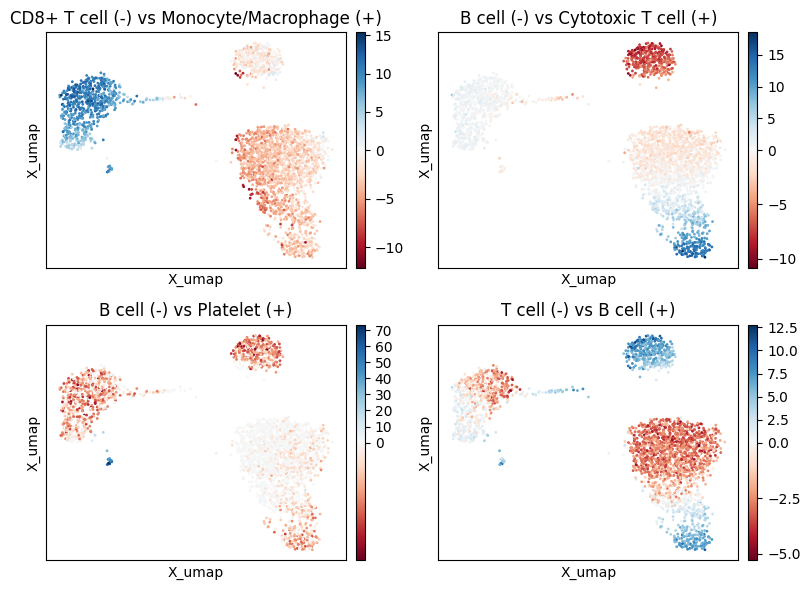

In [17]:
_ = sl.pl.factor_embedding(
    pbmc, 
    'pca', 
    factors=['0', '1', '2', '3'], 
    basis='X_umap', 
    annotation='pca_annotation',
    ncols=2
    )
plt.tight_layout()

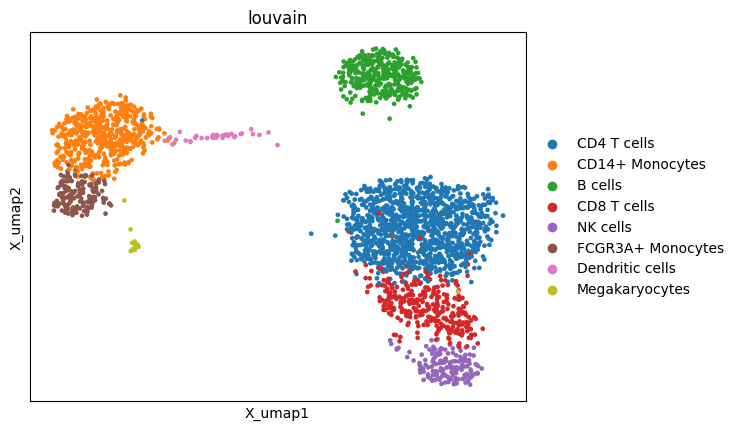

In [18]:
sc.pl.embedding(pbmc, 'X_umap', color='louvain')

## Angelidis

In this example we will use the `annotate_cluster` function to annotate the cells in the Angelidis dataset.

In [19]:
angelidis = sc.read_h5ad('/Users/harald/Downloads/umap_1.h5ad')

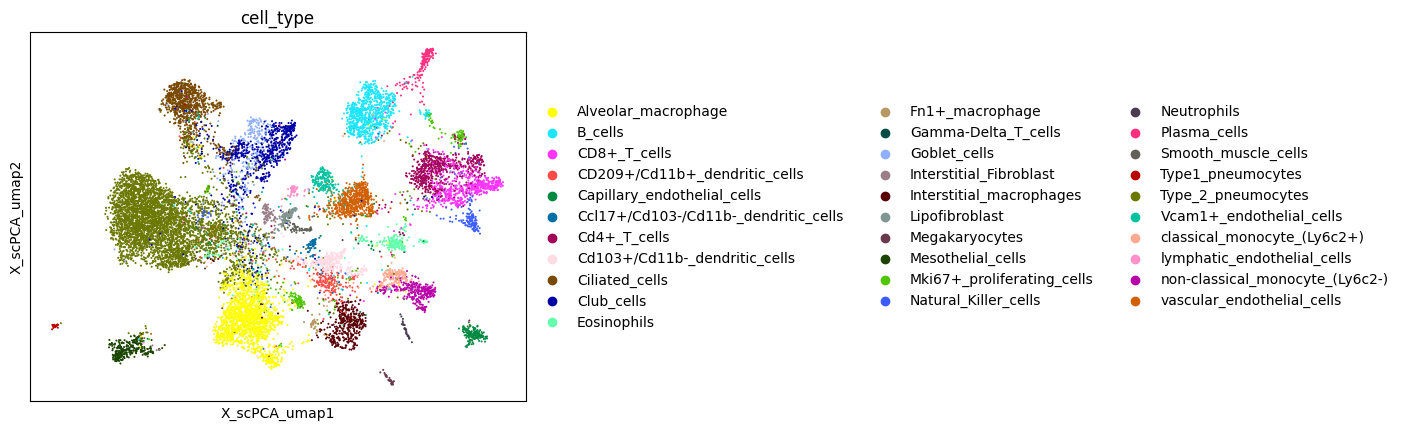

In [20]:
sc.pl.embedding(angelidis, 'X_scPCA_umap', color='cell_type')

In [21]:
angelidis

AnnData object with n_obs × n_vars = 14064 × 4000
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id', 'super'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'X_scPCA', 'celltype_column', 'condition_column', 'hvg', 'log1p', 'main_assay', 'scPCA', 'umap', 'cell_type_colors'
    obsm: 'X_scPCA', 'X_scPCA_umap'
    varm: 'V_scPCA', 'W_scPCA', 'α_scPCA', 'σ_scPCA'
    layers: 'counts', 'offset_scPCA', 'μ_scPCA'
    obsp: 'X_scPCA_connectivities', 'X_scPCA_distances'

In [22]:
angelidis.varm['W_scpca_ref'] = angelidis.varm['W_scPCA'][..., 0]

In [23]:
sl.tl.annotate_factor(
    angelidis, 
    'W_scpca_ref', 
    llm,
    factors=['0', '1', '2', '3', '4', '5', '6'], 
    top_genes=40, 
    key_added='scpca_annotation'
)

In [24]:
angelidis.uns['scpca_annotation']

[{'factor': '0', 'sign': '+', 'cell_type': 'Ciliated Epithelial Cell'},
 {'factor': '0', 'sign': '-', 'cell_type': 'Macrophage'},
 {'factor': '1', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '1', 'sign': '-', 'cell_type': 'Alveolar Type II Cell'},
 {'factor': '2', 'sign': '+', 'cell_type': 'Club Cells'},
 {'factor': '2', 'sign': '-', 'cell_type': 'B cell'},
 {'factor': '3', 'sign': '+', 'cell_type': 'B cell'},
 {'factor': '3', 'sign': '-', 'cell_type': 'Endothelial cells'},
 {'factor': '4', 'sign': '+', 'cell_type': 'Macrophage'},
 {'factor': '4', 'sign': '-', 'cell_type': 'B cell'},
 {'factor': '5', 'sign': '+', 'cell_type': 'Endothelial Cell'},
 {'factor': '5', 'sign': '-', 'cell_type': 'Ciliated Epithelial Cell'},
 {'factor': '6', 'sign': '+', 'cell_type': 'CD8+ T cell'},
 {'factor': '6', 'sign': '-', 'cell_type': 'Dendritic Cell'}]

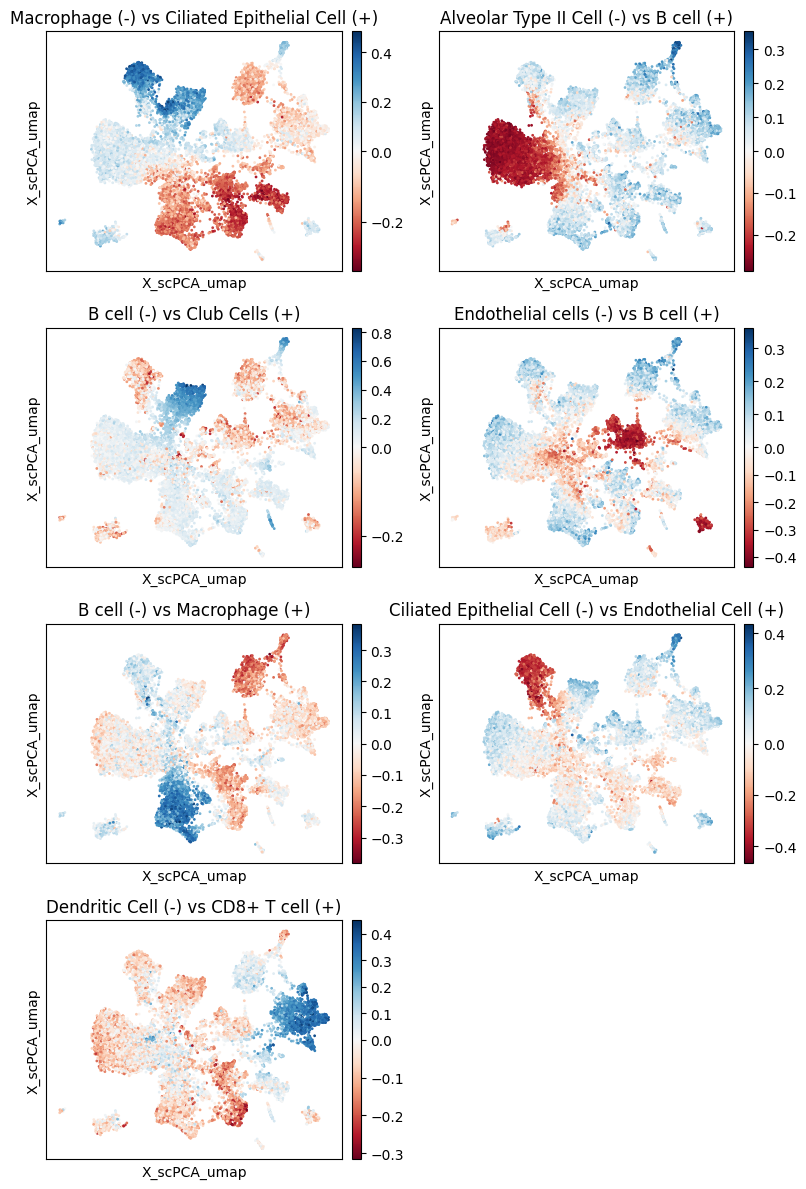

In [25]:
_ = sl.pl.factor_embedding(
    angelidis, 
    'scPCA', 
    factors=['0', '1', '2', '3', '4', '5', '6'], 
    basis='X_scPCA_umap', 
    annotation='scpca_annotation',
    ncols=2
    )
plt.tight_layout()